In [1]:
import working_dir
working_dir.set_wd()
working_dir.get_wd()

'/Users/tales.pimentel/ds/learning/audit2022p'

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [3]:
from src.dao import data_globals
from src.processing import entidade_urna
from src.utils import stats, dflib
from src.utils import pretties as prt

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
FILEPATH_PROC_ESTADOS = data_globals.FILEPATH_PROC_ESTADOS
FILEPATH_PROC_IBGE_SHAPEFILE = data_globals.FILEPATH_PROC_IBGE_SHAPEFILE
FILEPATH_PROC_TSE_BOLETINS_DE_URNA_2T = data_globals.FILEPATH_PROC_TSE_BOLETINS_DE_URNA_2T

# Carregando dados

## Estados

In [6]:
estados = pd.read_csv(FILEPATH_PROC_ESTADOS, sep=";")

cols_locais = ["REGIAO", "ESTADO", "CAPITAL"]

estados[cols_locais] = estados[cols_locais].apply(lambda col : col.str.upper())
estados[cols_locais] = estados[cols_locais].apply(lambda col: dflib.remove_acento_list(col.str.upper()))

estados.sample(5)

,SIGLA,ESTADO,REGIAO,CAPITAL
6,DF,DISTRITO FEDERAL,CENTRO OESTE,BRASILIA
7,ES,ESPIRITO SANTO,SUDESTE,VITORIA
5,CE,CEARA,NORDESTE,FORTALEZA
14,PB,PARAIBA,NORDESTE,JOAO PESSOA
16,PE,PERNAMBUCO,NORDESTE,RECIFE


## Boletins de Urna

In [7]:
DFBU_COLS = ['SG_UF', 'CD_MUNICIPIO', 'NM_MUNICIPIO', 
             'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO', "NM_LOCAL_VOTACAO",
             'NR_PARTIDO', 'QT_APTOS', 'QT_COMPARECIMENTO', 'QT_ABSTENCOES',
             'DS_TIPO_VOTAVEL', 'NR_VOTAVEL', 'NM_VOTAVEL', 'QT_VOTOS',
             'NR_URNA_EFETIVADA', "modelo_urna"]

DFBU_DTYPE = {'SG_UF': str, 'CD_MUNICIPIO': str, 'NM_MUNICIPIO': str, 
              'NR_ZONA': str, 'NR_SECAO': str, 'NR_LOCAL_VOTACAO': str,
              'NR_PARTIDO': str, 'QT_APTOS': int, 'QT_COMPARECIMENTO': int, 'QT_ABSTENCOES': int,
              'DS_TIPO_VOTAVEL': str, 'NR_VOTAVEL': str, 'NM_VOTAVEL': str, 'QT_VOTOS': int,
              'NR_URNA_EFETIVADA': str, "modelo_urna": str}

In [8]:
CORES_CANDIDATOS = {"13": "#de0100", "22": "#1f5f5b"}

MODELO_URNA_BINARIO = {"2020": "modelo 2020", "2009": "modelo anterior", 
                       "2010": "modelo anterior", "2011": "modelo anterior", 
                       "2013": "modelo anterior", "2015": "modelo anterior"}

In [9]:
ESTADO = "Brasil"

In [10]:
dfbu = pd.read_csv(FILEPATH_PROC_TSE_BOLETINS_DE_URNA_2T, sep=";", encoding='latin1', 
                   usecols=DFBU_COLS, dtype=DFBU_DTYPE)

dfbu["modelo_urna_binario"] = dfbu["modelo_urna"].replace(MODELO_URNA_BINARIO)

if ESTADO != "Brasil":
    dfbu = dfbu[dfbu["SG_UF"] == ESTADO]

print("dfbu.shape", dfbu.shape)

dfbu.shape (1850891, 18)


In [11]:
dfbu.sample(5)

,SG_UF,CD_MUNICIPIO,NR_ZONA,NR_SECAO,NR_LOCAL_VOTACAO,NR_PARTIDO,QT_APTOS,QT_COMPARECIMENTO,QT_ABSTENCOES,DS_TIPO_VOTAVEL,NR_VOTAVEL,NM_VOTAVEL,QT_VOTOS,NR_URNA_EFETIVADA,modelo_urna,NM_MUNICIPIO,NM_LOCAL_VOTACAO,modelo_urna_binario
1713310,SP,61727,361,109,1376,-1,383,326,57,Branco,95,Branco,11,1804444,2015,HORTOLANDIA,EE. YASSUO SASAKI,modelo anterior
1355908,SC,82970,15,116,1066,-1,377,326,51,Nulo,96,Nulo,8,1100292,2009,RODEIO,ESCOLA DE EDUCAÃÃO FUNDAMENTAL SENADOR FRANC...,modelo anterior
1844629,TO,73440,29,430,1791,-1,366,307,59,Nulo,96,Nulo,4,1783824,2015,PALMAS,ESCOLA MUNICIPAL DE TEMPO INTEGRAL DANIEL BATISTA,modelo anterior
1621095,SP,70777,269,161,1074,-1,408,344,64,Branco,95,Branco,5,1805524,2015,SAO CAETANO DO SUL,EE. PROFESSOR ALFREDO BURKART,modelo anterior
547062,MG,41238,28,336,1880,-1,478,406,72,Nulo,96,Nulo,14,2035474,2020,BELO HORIZONTE,COLEGIO NORMAL FREDERICO OZANAN,modelo 2020


# Tabela da entidade Urna Eletrônica
A variável dfu representa a votação a nível de Urna Eletrônica.
A variável dfbu representa a entidade 'votação de um candidato em uma urna eletrônica'.

In [12]:
index_urna = ["SG_UF", "NR_ZONA", "NR_SECAO", "CD_MUNICIPIO", "NR_LOCAL_VOTACAO", "NR_URNA_EFETIVADA", 
              "modelo_urna", "modelo_urna_binario", "NM_MUNICIPIO", "NM_LOCAL_VOTACAO"]

dfu = dfbu.pivot(columns="NR_VOTAVEL", values="QT_VOTOS", index=index_urna)
dfu = dfu.reset_index().rename(columns={"96": "Nulo", "95": "Branco"})
dfu.columns.name = None
dfu[["13", "22", "Branco", "Nulo"]] = dfu[["13", "22", "Branco", "Nulo"]].fillna(0).astype(int)

dfu.sample(8)

,SG_UF,NR_ZONA,NR_SECAO,CD_MUNICIPIO,NR_LOCAL_VOTACAO,NR_URNA_EFETIVADA,modelo_urna,modelo_urna_binario,NM_MUNICIPIO,NM_LOCAL_VOTACAO,13,22,Branco,Nulo
157102,MG,318,133,45535,1198,1833431,2015,modelo anterior,GOVERNADOR VALADARES,ESCOLA ESTADUAL MANOEL BYRRO,121,157,3,2
258873,PR,3,101,75353,1147,2004808,2020,modelo 2020,CURITIBA,ESCOLA MUNICIPAL PREFEITO OMAR SABBAG,91,157,10,6
350314,SC,3,664,80470,2208,2180544,2020,modelo 2020,BLUMENAU,ESCOLA BÃSICA MUNICIPAL ALBERTO STEIN,71,253,4,6
320884,RS,119,44,85014,1309,1632930,2011,modelo anterior,AGUDO,ESCOLA MUNICIPAL TRÃS DE MAIO,88,113,4,2
435847,SP,378,386,62910,1198,2167604,2020,modelo 2020,CAMPINAS,E.E. DR. ANTONIO PIRES BARBOSA,87,139,4,6
262064,PR,45,41,76597,1163,1262191,2010,modelo anterior,LARANJEIRAS DO SUL,ESCOLA ESTADUAL LARANJEIRAS DO SUL,99,162,0,5
289108,RJ,229,267,60011,1414,2164882,2020,modelo 2020,RIO DE JANEIRO,COLÃGIO PEDRO II,160,132,4,15
362063,SE,19,101,31674,1082,1609269,2011,modelo anterior,JAPOATA,ESCOLA ESTADUAL JÃLIO SILVA,117,27,3,4


,Absoluto,Relativo
2020,192691,0.408220
2010,93795,0.198707
2015,85735,0.181632
2009,48245,0.102208
2011,26889,0.056965
2013,24672,0.052268


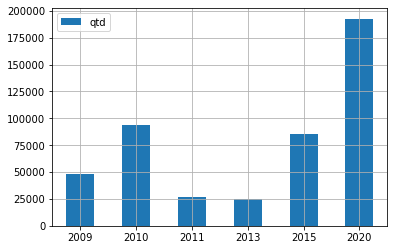

In [13]:
qtd_urnas = dfu["modelo_urna"].astype(str).value_counts().to_frame("qtd").sort_index()
prt.display(stats.freq(dfu["modelo_urna"].astype(str)))
qtd_urnas.plot.bar(rot=0, grid=True)
plt.show()

In [14]:
# SAO PAULO
# Jair Bolsonaro: 14.216.587 (55,24%) 
# Lula 11.519.882 (44,76%)

# PARAIBA
# Lula (PT): 66,62% dos votos válidos (1.601.953 votos)
# Jair Bolsonaro (PL): 33,38% dos votos válidos (802.502 votos)

# BRASIL
# Lula 60.345.999 votos (50,90% dos votos válidos)
# Jair Bolsonaro 58.206.354 votos (49,10% dos votos válidos).

votos_validos = dfu[["13", "22"]].sum().to_frame("votos")
votos_validos["%"] = votos_validos / votos_validos.sum()
prt.display(votos_validos)

,votos,%
13,60345999,0.509024
22,58206354,0.490976


# <font color='magenta'>Distribuição de Modelos de Urna</font>
Daqui em diante a análise considerará apenas urnas em território brasileiro.

In [15]:
print("A variavel 'modelos_cidade' representa a contagem 'modelo_urna_binario' por município")
modelos_cidade = dfu.groupby(["SG_UF", "NM_MUNICIPIO"]).apply(lambda g : stats.freq(g["modelo_urna_binario"])).reset_index().rename(columns={"level_2": "modelo_urna_binario"})
modelos_cidade = modelos_cidade[modelos_cidade["SG_UF"] != "ZZ"]
prt.display(modelos_cidade.sample(8))

A variavel 'modelos_cidade' representa a contagem 'modelo_urna_binario' por município


,SG_UF,NM_MUNICIPIO,modelo_urna_binario,Absoluto,Relativo
1908,MG,PARA DE MINAS,modelo 2020,193,1.000000
2193,MG,VARJAO DE MINAS,modelo anterior,20,1.000000
4511,SC,COCAL DO SUL,modelo anterior,46,1.000000
1355,MA,VITORIA DO MEARIM,modelo anterior,92,1.000000
4861,SP,ARARAQUARA,modelo anterior,335,0.579585
1592,MG,DELFIM MOREIRA,modelo anterior,22,1.000000
1541,MG,COIMBRA,modelo anterior,20,1.000000
967,GO,DOVERLANDIA,modelo anterior,23,1.000000


In [16]:
print("A variavel 'qtd_modelos_cidade' representa a contagem diferentes 'modelo_urna_binario' por município")
qtd_modelos_cidade = modelos_cidade.groupby(["SG_UF", "NM_MUNICIPIO"]).apply(len).sort_values(ascending=False)
qtd_modelos_cidade = qtd_modelos_cidade.to_frame("qtd_modelo_urna_binario").reset_index()
qtd_modelos_cidade.sample(8)

A variavel 'qtd_modelos_cidade' representa a contagem diferentes 'modelo_urna_binario' por município


,SG_UF,NM_MUNICIPIO,qtd_modelo_urna_binario
4348,MT,ROSARIO OESTE,1
2926,GO,GOIATUBA,1
3209,MA,PAULO RAMOS,1
4604,PB,ITATUBA,1
3661,CE,IPAPORANGA,1
4806,PB,BANANEIRAS,1
1118,PE,BOM JARDIM,1
1383,PR,JANIOPOLIS,1


In [17]:
qtd_modelos_cidade_total = qtd_modelos_cidade.groupby("qtd_modelo_urna_binario").apply(len).to_frame("qtd")
qtd_modelos_cidade_total["%"] = qtd_modelos_cidade_total["qtd"] / qtd_modelos_cidade_total["qtd"].sum()

print("Quantidade de cidades que tiveram 1 ou 2 'modelo_urna_binario'")
print("O 'modelo_urna_binario' representa se é modelo 2020 ou anterior")
print(f"{int(qtd_modelos_cidade_total.loc[1]['qtd'])} cidades tiveram 100% das urnas de mesmo 'modelo_urna_binario' (ou só 2020 ou só anterior)")
prt.display(qtd_modelos_cidade_total)
print(f'{qtd_modelos_cidade_total["qtd"].sum()} cidades')

Quantidade de cidades que tiveram 1 ou 2 'modelo_urna_binario'
O 'modelo_urna_binario' representa se é modelo 2020 ou anterior
5259 cidades tiveram 100% das urnas de mesmo 'modelo_urna_binario' (ou só 2020 ou só anterior)


,qtd,%
qtd_modelo_urna_binario,,
1,5259,0.944165
2,311,0.055835


5570 cidades


### Anotações
Uma alta quantidade de cidades tiveram apenas `modelo_urna_binario` (modelo 2020 ou modelo anterior).

In [20]:
df_gpd = gpd.read_file(FILEPATH_PROC_IBGE_SHAPEFILE)

if ESTADO != "Brasil":
    df_gpd = df_gpd[df_gpd["SIGLA"] == ESTADO]
    

print("Cidades brasileiras da base do TSE que estão na base IBGE de Shapefile")
tem_tse_tem_shp = (qtd_modelos_cidade["SG_UF"] + " " + qtd_modelos_cidade["NM_MUNICIPIO"]).drop_duplicates().isin(df_gpd["SIGLA"] + " " + df_gpd["NM_MUN"])

prt.display(stats.freq(tem_tse_tem_shp))

print("Nomes de cidade no TSE que não estão no Shapefile")

prt.display(qtd_modelos_cidade[tem_tse_tem_shp == False].sort_values("NM_MUNICIPIO")[["SG_UF", "NM_MUNICIPIO"]])

print()
print("modelos_cidade.shape", modelos_cidade.shape)
modelos_gpd = modelos_cidade.merge(df_gpd[["NM_MUN", "SIGLA", "AREA_KM2", "geometry"]], 
                                   left_on=["NM_MUNICIPIO", "SG_UF"], 
                                   right_on=["NM_MUN", "SIGLA"], 
                                   how="left").drop(["NM_MUN", "SIGLA"], axis=1)
print("modelos_cidade.shape", modelos_cidade.shape)
modelos_gpd = modelos_gpd.merge(estados, how="left",
                                left_on=["SG_UF"], right_on=["SIGLA"])
print("modelos_cidade.shape", modelos_cidade.shape)

modelos_gpd = gpd.GeoDataFrame(modelos_gpd)
print("\nAmostra de cidades identificadas")
modelos_gpd["cor_gradiente_modelo_urna_bin"] = modelos_gpd.apply(lambda row : entidade_urna.cor_gradiente(row), axis=1)
modelos_gpd["cor_modelo_urna_bin"] = modelos_gpd["modelo_urna_binario"].replace(entidade_urna.COLOR_MODELO_URNA_BIN)
print("modelos_cidade.shape", modelos_cidade.shape)
# prt.display(modelos_gpd.sample(min(5, len(modelos_gpd))))

Cidades brasileiras da base do TSE que estão na base IBGE de Shapefile


,Absoluto,Relativo
True,5569,0.99982
False,1,0.00018


Nomes de cidade no TSE que não estão no Shapefile


,SG_UF,NM_MUNICIPIO
822,RN,BOA SAUDE



modelos_cidade.shape (5881, 5)
modelos_cidade.shape (5881, 5)
modelos_cidade.shape (5881, 5)

Amostra de cidades identificadas
modelos_cidade.shape (5881, 5)


modelos_gpd_cores_not_na 5569
total cidades 5569

Estado: Brasil


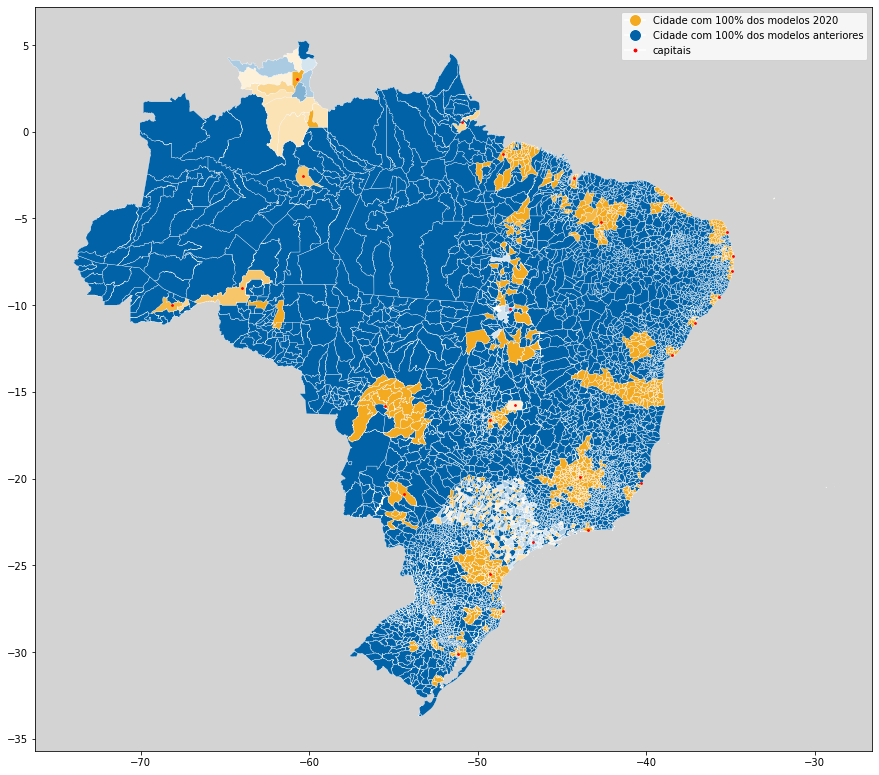

In [19]:
modelos_gpd_cores = modelos_gpd[~modelos_gpd["cor_gradiente_modelo_urna_bin"].isna()]

capitais = modelos_gpd[modelos_gpd["NM_MUNICIPIO"] == modelos_gpd["CAPITAL"]].drop_duplicates(subset=["SG_UF", "NM_MUNICIPIO"])[["SG_UF", "NM_MUNICIPIO", "geometry"]].sort_values("SG_UF")

modelos_gpd_cores_not_na = modelos_gpd_cores.dropna(subset=["geometry"])
duplicatas_por_serem_05_relativo_i = modelos_gpd_cores_not_na[modelos_gpd_cores_not_na["Relativo"] == 0.5].drop_duplicates(subset=["SG_UF", "NM_MUNICIPIO"]).index
modelos_gpd_cores_not_na = modelos_gpd_cores_not_na.drop(index=duplicatas_por_serem_05_relativo_i)
print("modelos_gpd_cores_not_na", len(modelos_gpd_cores_not_na))
print("total cidades", len(modelos_gpd_cores_not_na[["SG_UF", "NM_MUNICIPIO"]].drop_duplicates()))

print()
print(f"Estado: {ESTADO}")

if ESTADO == "Brasil":
    linewidth = 0.3
else:
    linewidth = 0.50

p = modelos_gpd_cores_not_na.plot(color=modelos_gpd_cores_not_na["cor_gradiente_modelo_urna_bin"], 
                                  figsize=(15,15), linewidth=linewidth, edgecolor="white")

capitais.representative_point().plot(ax=p, marker='.', color='red', markersize=12);

p.set_facecolor('lightgray')

line1 = Line2D([], [], color="white", marker='o', markersize=12, 
               markerfacecolor=entidade_urna.COLOR_MODELO_URNA_BIN["modelo 2020"])
line2 = Line2D([], [], color="white", marker='o', markersize=12, 
               markerfacecolor=entidade_urna.COLOR_MODELO_URNA_BIN["modelo anterior"])
line3 = Line2D([], [], color="white", marker='.', markersize=10, 
               markerfacecolor="red")

plt.legend((line1, line2, line3), ("Cidade com 100% dos modelos 2020", 
                                   "Cidade com 100% dos modelos anteriores", 
                                   "capitais"), numpoints=1, loc=1)

plt.show()

### Anotações
Cada demarcação no mapa representa um município. As cores representam a proporção de urnas de `modelo 2020` e `modelo anterior`. As cores mais claras indicam que o município não teve só um tipo de modelo de urna.<br>
<br>
Este gráfico se destaca pela alta concentração de cidades que só possuem ou modelo 2020 ou modelo anterior, o que pode ajudar a explicar por que tanta diferença na totalização de votos por modelo de urna.<br>
<br>
Outro ponto interessante é que quase todas as capitais tiveram apenas urnas de modelo 2020. Não só as capitais mas várias cidades vizinhas também.<br>
A capital e cidades vizinhas são pontos onde, no geral, concentram mais recursos, mais investimentos públicos e privados. É, além do centro político do estado, um centro de maior atividade econômica.<br>
<br>
Este gráfico desperta o interesse por analisar melhor os locais onde as urnas foram colocadas, em especial no aspecto econômico ou financeiro. Considerando este objetivo, a análise 2.3 tratou de cruzar dados de PIB Per Capita destas cidades. Esta análise 2.3 se encontra disponível em outro arquivo deste mesmo diretório.